# Predicting Diabetes Risk Using Clinical and Demographic Features

## Introduction
Diabetes is a chronic health condition that affects the body’s ability to process blood glucose, and it can lead to serious long-term complications if not detected and managed early. In this project, I explore whether commonly collected clinical and demographic factors can be used to predict the likelihood of diabetes.

The goal of this analysis is to:
1. Understand relationships between variables such as glucose levels, BMI, blood pressure, age, and diabetes outcome.
2. Build predictive models using machine learning to classify individuals into diabetic or non-diabetic categories.
3. Evaluate model performance and interpret feature importance to gain insights into potential risk factors.

---

In [1]:
# Importing the required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning tools
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.dummy import DummyClassifier


In [2]:
# Load data
df = pd.read_csv("data/diabetes.csv")
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


## Dataset Description

The dataset used in this project is the Pima Indians Diabetes dataset, which contains medical and demographic information for women of Pima Indian heritage aged 21 years and older. The dataset includes 768 observations and 9 variables, where the target variable `Outcome` indicates whether an individual is likely diabetic (1) or not (0).

### Features Included
| Feature | Description |
|---------|-------------|
| Pregnancies | Number of times pregnant |
| Glucose | Plasma glucose concentration (2-hour oral glucose tolerance test) |
| BloodPressure | Diastolic blood pressure (mm Hg) |
| SkinThickness | Triceps skinfold thickness (mm) |
| Insulin | 2-hour serum insulin (mu U/ml) |
| BMI | Body mass index (weight in kg/(height in m)^2) |
| DiabetesPedigreeFunction | Family history-based diabetes risk score |
| Age | Age in years |
| Outcome | 1 = diabetic, 0 = non-diabetic |

Before cleaning and modeling, we will explore data structure, types, missing values, and statistical distributions.


In [3]:
# Display dataset shape
print("Dataset Shape:", df.shape)

# Show data types and missing values
display(df.info())

# Summary statistics
df.describe()


Dataset Shape: (768, 9)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


None

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


## Data Quality Observation

Although there are no `NaN` values shown in the dataset, several variables contain zero values that are not clinically plausible. For example, `Glucose`, `BloodPressure`, `SkinThickness`, `Insulin`, and `BMI` cannot realistically be zero for a living adult. These zeros likely represent missing or unrecorded measurements.

To ensure the integrity of the analysis and avoid bias in the model, we will treat these zero values as missing (`NaN`) and apply an appropriate imputation method using the median value of each affected feature.


In [4]:
# Identify columns where zero is not a valid value
invalid_zero_cols = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]

# Replace zero values with NaN
df[invalid_zero_cols] = df[invalid_zero_cols].replace(0, np.nan)

# Display number of missing values per column
print("Missing values after replacement:")
print(df.isnull().sum())

# Impute missing values with median
df[invalid_zero_cols] = df[invalid_zero_cols].fillna(df[invalid_zero_cols].median())

# Confirm no missing values remain
print("\nMissing values after imputation:")
print(df.isnull().sum())


Missing values after replacement:
Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

Missing values after imputation:
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


## Exploratory Data Analysis (EDA)

In this step, we explore the structure and distribution of the dataset to identify patterns, detect potential outliers, and understand relationships between features and the diabetes outcome variable. EDA helps guide modeling decisions and provides useful insights into which features may influence diabetes risk.

We begin by examining:
- The distribution of the target variable (`Outcome`)
- Summary statistics and feature distributions
- Potential relationships between features and diabetes status


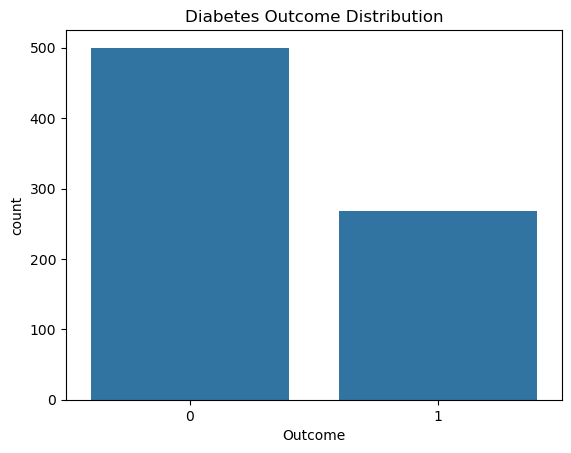

Class Counts:
 Outcome
0    500
1    268
Name: count, dtype: int64

Class Percentages:
 Outcome
0    65.1
1    34.9
Name: count, dtype: float64


In [5]:
# Count plot for class distribution
sns.countplot(x='Outcome', data=df)
plt.title("Diabetes Outcome Distribution")
plt.savefig("images/diabetes_outcome_distribution.png", 
            dpi=300, bbox_inches="tight") # Saving the plot.
plt.show()

# Show raw counts and percentages
counts = df['Outcome'].value_counts()
percentages = (counts / len(df)) * 100

print("Class Counts:\n", counts)
print("\nClass Percentages:\n", percentages.round(2))

### Class Distribution Observation

The dataset shows a moderate class imbalance, with approximately 65% of observations labeled as non-diabetic (Outcome = 0) and 35% labeled as diabetic (Outcome = 1). This indicates that while most individuals in the dataset do not have diabetes, the minority diabetic class is still substantial.

Due to this imbalance, accuracy alone will not be a reliable measure of model performance. Instead, metrics such as precision, recall, F1-score, and ROC-AUC will be considered to properly evaluate how well the model predicts both classes.

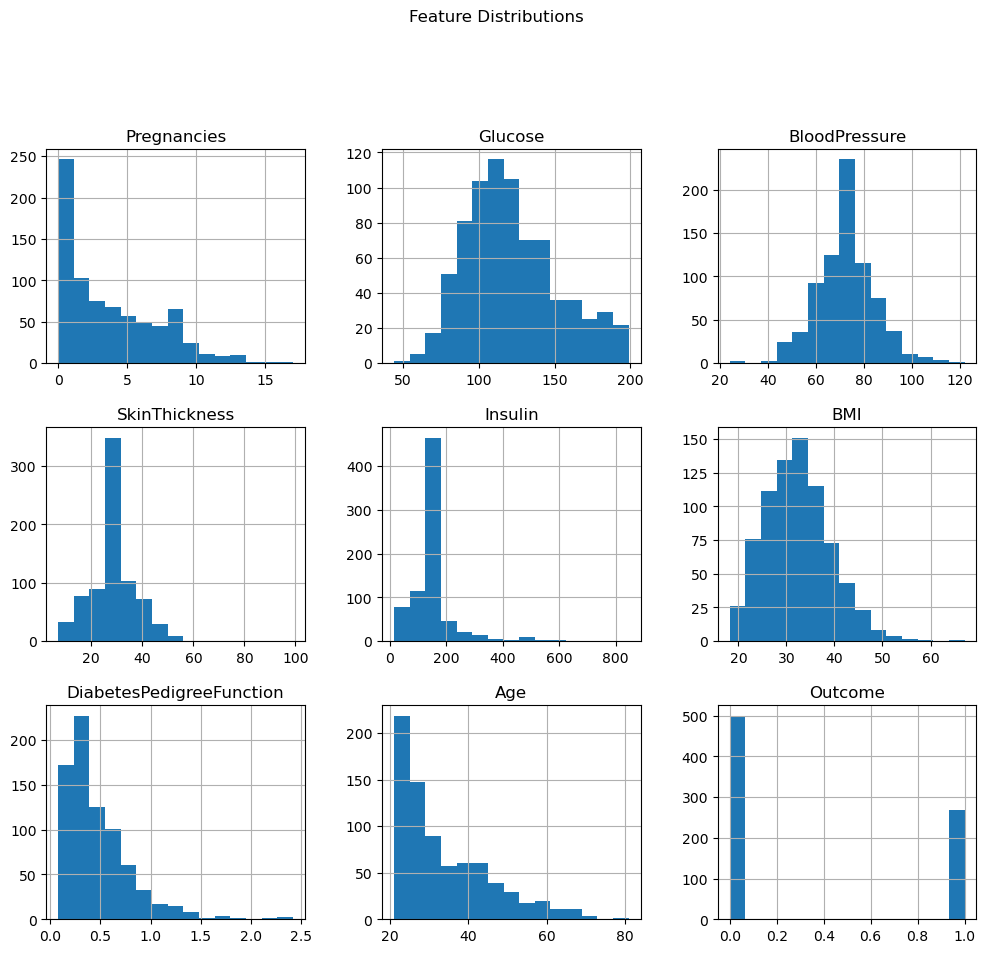

In [6]:
# Plot histograms for feature distributions
df.hist(bins=15, figsize=(12, 10))
plt.suptitle("Feature Distributions", y=1.02)
plt.savefig("images/feature_distributions.png", 
            dpi=300, bbox_inches="tight") # Saving the plot.
plt.show()


### Feature Distribution Analysis

The distribution plots show how each feature is spread across the dataset:

- **Pregnancies:** Most participants had between 0–6 pregnancies, with a few women having a much higher number, causing a slight positive skew.
- **Glucose:** Generally right-skewed with most values clustering between 80–140 mg/dL, indicating that a minority have very high glucose levels.
- **BloodPressure:** Approximately symmetric, with most values around 60–80 mm Hg and few outliers.
- **SkinThickness:** Slightly right-skewed, with a long tail towards higher values, suggesting some extreme measurements.
- **Insulin:** Highly right-skewed and contains extreme values, indicating some participants have unusually high insulin measurements.
- **BMI:** Slightly positively skewed; most participants fall within the overweight to obese range.
- **DiabetesPedigreeFunction:** Right-skewed, with a few individuals having very high genetic risk scores.
- **Age:** Slight positive skew with most participants in their 20s–40s, and some older individuals.
- **Outcome:** Moderately imbalanced with more non-diabetic (0) than diabetic (1) participants.

**Key Takeaways:**
- Features like **Insulin, SkinThickness, and DiabetesPedigreeFunction** are highly skewed, which could affect certain models and may benefit from transformations.
- Most other features have distributions that can be used directly in modeling.
- Understanding these distributions is essential to choose proper preprocessing, model selection, and interpretation strategies.


### Feature Relationships and Correlation

To better understand which features are predictive of diabetes and how features relate to each other, we examine:

1. **Correlation Heatmap**: Measures the linear relationships between all numerical variables, including the target variable `Outcome`.  
   - Features highly correlated with `Outcome` may have more predictive power.  
   - Highly correlated features with each other may introduce redundancy in certain models.

2. **Boxplots by Outcome**: Visual comparison of feature distributions between non-diabetic (`Outcome=0`) and diabetic (`Outcome=1`) participants.  
   - Helps identify features with clear differences between classes.
   - Provides insight into potential risk factors.


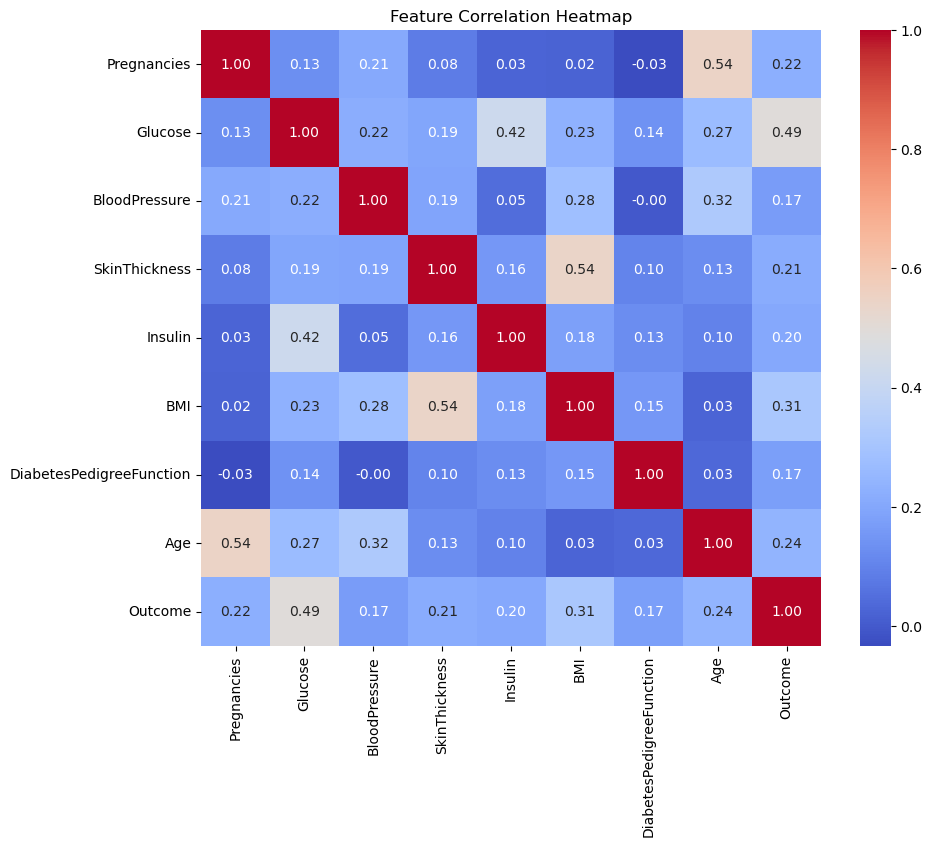

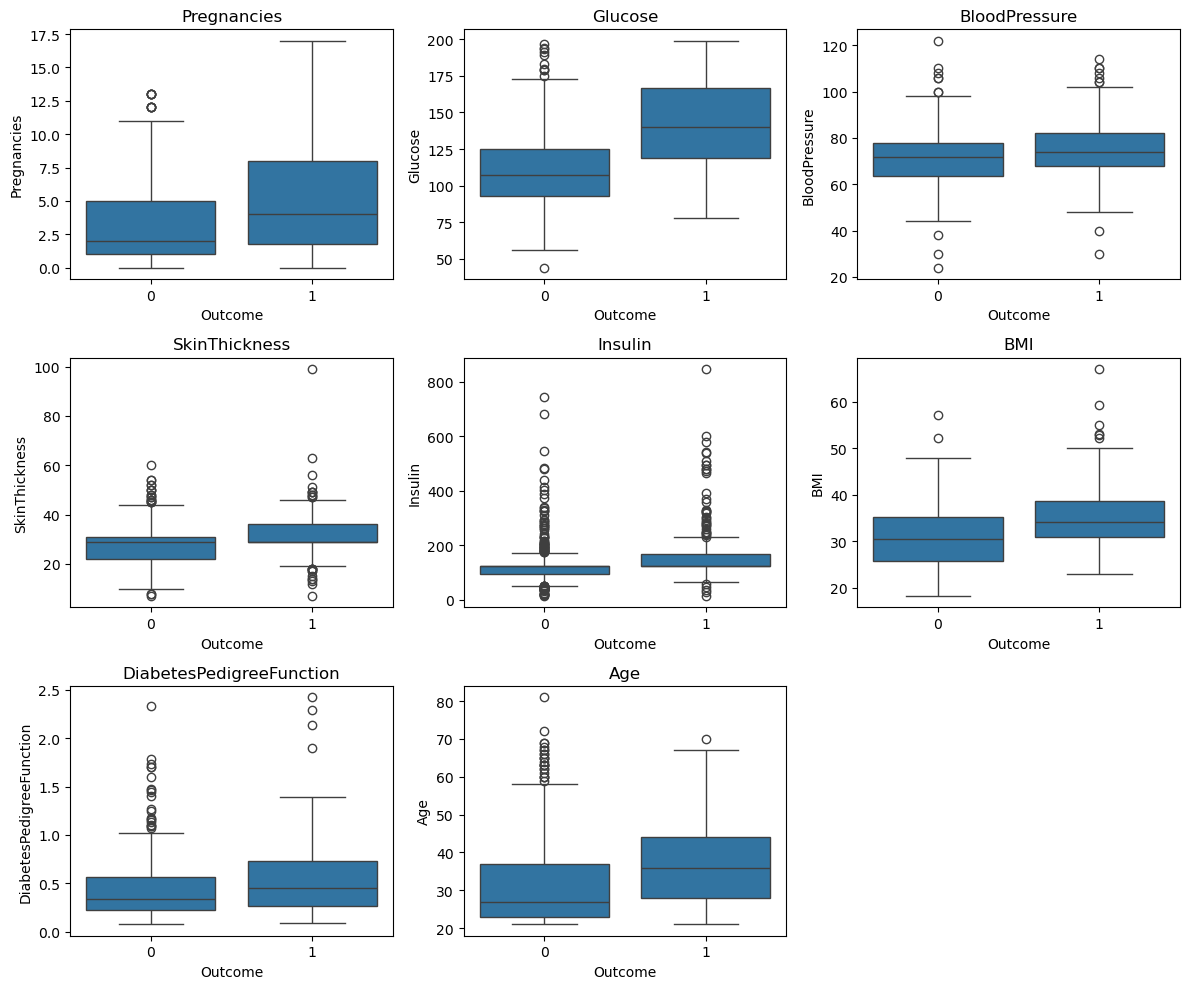

In [7]:
# Correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Feature Correlation Heatmap")
plt.savefig("images/feature_correlation_heatmap.png", 
            dpi=300, bbox_inches="tight") # Saving the plot.
plt.show()

# Boxplots for features by Outcome
plt.figure(figsize=(12, 10))
for i, col in enumerate(df.columns[:-1]):
    plt.subplot(3, 3, i+1)
    sns.boxplot(x='Outcome', y=col, data=df)
    plt.title(col)
plt.tight_layout()
plt.savefig("images/boxplots_for_features_by_outcome.png", 
            dpi=300, bbox_inches="tight") # Saving the plot.
plt.show()


### Feature Relationships with Diabetes Outcome

#### Correlation Analysis
The Pearson correlation coefficients between each feature and the target variable `Outcome` show which features are most strongly associated with diabetes:

- **Glucose** has the highest positive correlation with Outcome (≈ 0.49), indicating that higher glucose levels are strongly associated with diabetes.  
- **BMI** (≈ 0.31) and **Age** (≈ 0.24) also show moderate positive correlations.  
- Other features such as **Pregnancies, SkinThickness, Insulin, DiabetesPedigreeFunction, and BloodPressure** show weaker positive correlations (≈ 0.16–0.22).

#### Class-Separated Statistics
Comparing the mean and median of each feature between non-diabetic (Outcome = 0) and diabetic (Outcome = 1) participants:

| Feature | Mean (0) | Mean (1) | Median (0) | Median (1) |
|---------|-----------|-----------|------------|------------|
| Pregnancies | 3.30 | 4.87 | 2 | 4 |
| Glucose | 110.68 | 142.13 | 107.5 | 140 |
| BloodPressure | 70.92 | 75.12 | 72 | 74 |
| SkinThickness | 27.73 | 31.69 | 29 | 29 |
| Insulin | 127.79 | 164.70 | 125 | 125 |
| BMI | 30.89 | 35.38 | 30.40 | 34.25 |
| DiabetesPedigreeFunction | 0.43 | 0.55 | 0.34 | 0.45 |
| Age | 31.19 | 37.07 | 27 | 36 |

**Observations:**
- Diabetic participants generally have higher **Glucose, BMI, Age, Insulin, SkinThickness, and DiabetesPedigreeFunction** values compared to non-diabetics.  
- The differences are most pronounced for **Glucose** and **BMI**, aligning with their stronger correlation coefficients.  
- Some features (e.g., SkinThickness, Insulin) show considerable spread and overlapping distributions, indicating that they contribute to risk but are not individually decisive.

**Key Takeaway:**  
Features with the strongest correlation and class separation, particularly **Glucose and BMI**, will likely be the most influential in predictive modeling. Less correlated features can still add incremental predictive value when combined in a multivariate model.


## Data Preparation for Modeling

Before building predictive models, we need to:

1. **Split the dataset** into training and test sets.  
   - The **training set** is used to fit the model.  
   - The **test set** is held out for evaluating model performance on unseen data.  
   - A common split is 80% training and 20% testing.

2. **Scale numerical features** using standardization (z-score scaling).  
   - This ensures that features with different units and ranges (e.g., Glucose, Age, BMI) are on a comparable scale.  
   - Scaling is particularly important for models that rely on distances or gradient-based optimization, such as Logistic Regression.

3. **Baseline model**:  
   - A simple dummy classifier predicting the majority class.  
   - Provides a reference accuracy score to compare more advanced models.


In [8]:
# Separate features and target
X = df.drop('Outcome', axis=1)
y = df['Outcome']

# Train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Baseline model (majority class)
baseline = DummyClassifier(strategy='most_frequent')
baseline.fit(X_train_scaled, y_train)
baseline_pred = baseline.predict(X_test_scaled)

# Baseline evaluation
from sklearn.metrics import classification_report, confusion_matrix

print("Baseline Accuracy:", baseline.score(X_test_scaled, y_test))
print("\nClassification Report:\n", classification_report(y_test, baseline_pred))


Baseline Accuracy: 0.6493506493506493

Classification Report:
               precision    recall  f1-score   support

           0       0.65      1.00      0.79       100
           1       0.00      0.00      0.00        54

    accuracy                           0.65       154
   macro avg       0.32      0.50      0.39       154
weighted avg       0.42      0.65      0.51       154



D:\ANACONDA\envs\DATA_SCIENCE\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
D:\ANACONDA\envs\DATA_SCIENCE\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
D:\ANACONDA\envs\DATA_SCIENCE\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


## Baseline Model Evaluation

Before building predictive models, we establish a baseline using a simple **majority-class classifier**, which always predicts the most frequent class (`Outcome = 0`, non-diabetic). This provides a reference point to assess whether our predictive models add value.

### Baseline Model Results
- **Accuracy:** ~64.9%  
  - Matches the proportion of non-diabetic participants in the dataset (~65%).  
  - Shows that a naïve model can achieve reasonable accuracy by always predicting the majority class.
  
- **Class-specific performance:**
  - **Non-diabetic (0):** Precision ≈ 0.65, Recall = 1.0, F1-score ≈ 0.79  
    - The model correctly identifies all non-diabetic cases because it always predicts 0.
  - **Diabetic (1):** Precision = 0.0, Recall = 0.0, F1-score = 0.0  
    - The model fails to predict any diabetic cases, which highlights the need for a real model that can identify the minority class.

### Key Takeaways
- The baseline model provides a **minimum performance benchmark**.
- Any meaningful predictive model must:
  1. Correctly identify some diabetic cases.
  2. Improve metrics for the minority class (recall, F1-score, ROC-AUC) while maintaining overall accuracy.


## Logistic Regression Model

Following the baseline model, we now build a **Logistic Regression** classifier. Logistic Regression is a widely used and interpretable statistical model suitable for binary classification tasks, such as predicting whether a patient is diabetic or not.

Key reasons for using Logistic Regression:
- It outputs **probabilities**, allowing flexible decision thresholds.
- Model coefficients provide **interpretability**, indicating the direction and magnitude of influence of each feature.
- It performs well on linearly separable data and serves as a strong baseline before trying more complex models.

We will:
1. Train the model using the standardized training set.
2. Make predictions on the test set.
3. Evaluate performance using:
   - Accuracy
   - Precision, Recall, F1-score
   - Confusion Matrix
   - ROC-AUC Score


In [9]:
# Initialize and train the model
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train_scaled, y_train)

# Predict on test set
y_pred = log_reg.predict(X_test_scaled)
y_proba = log_reg.predict_proba(X_test_scaled)[:, 1]

# Evaluation
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# ROC-AUC Score
roc_auc = roc_auc_score(y_test, y_proba)
print("\nROC-AUC Score:", roc_auc)


Logistic Regression Accuracy: 0.7077922077922078

Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.82      0.78       100
           1       0.60      0.50      0.55        54

    accuracy                           0.71       154
   macro avg       0.68      0.66      0.67       154
weighted avg       0.70      0.71      0.70       154

Confusion Matrix:
 [[82 18]
 [27 27]]

ROC-AUC Score: 0.812962962962963


## Logistic Regression Model Results & Interpretation

After training a Logistic Regression classifier, I evaluated its performance on the test set. Below is the summary of the model's performance metrics:

### Performance Summary
- **Accuracy:** ~70.8% — an improvement over the baseline accuracy of ~64.9%.
- **ROC-AUC Score:** ~0.813 — indicates good discrimination capability between diabetic and non-diabetic cases.

### Classification Performance by Class
| Metric | Class 0 (Non-diabetic) | Class 1 (Diabetic) |
|--------|-------------------------|---------------------|
| Precision | 0.75 | 0.60 |
| Recall | 0.82 | 0.50 |
| F1-score | 0.78 | 0.55 |

**Interpretation:**
- The model performs better for **non-diabetic (majority class)**, correctly identifying 82 out of 100 patients.
- For **diabetic (minority class)**, recall increases from **0.0 (baseline)** to **0.50**, meaning the model now correctly identifies **half of the diabetic cases**, a significant improvement.
- This aligns with typical performance challenges in **imbalanced medical datasets**, where identifying positive cases is harder.

### Confusion Matrix
|                | Predicted 0 | Predicted 1 |
|----------------|-------------|-------------|
| Actual 0       | 82          | 18          |
| Actual 1       | 27          | 27          |

- **False negatives (27)** remain an important concern since misclassifying diabetic patients can have clinical consequences.
- A future step may involve **adjusting decision thresholds**, **using class weights**, or **trying more advanced models** to improve recall for the positive class.

### Model Assessment
Compared to the baseline model (which predicted only the majority class), Logistic Regression:
- Correctly identifies diabetic patients
- Achieves higher performance across all key metrics
- Shows promising predictive power with an AUC above 0.80

Overall, Logistic Regression provides a **meaningful improvement** and serves as a strong **initial predictive model**.


## Logistic Regression Coefficients Interpretation

Logistic Regression provides a set of coefficients, one for each feature, which represent how much that feature influences the probability of diabetes (Outcome = 1). These coefficients come from the log-odds space:

- A **positive coefficient** means the feature **increases** the likelihood of diabetes.
- A **negative coefficient** means the feature **decreases** the likelihood of diabetes.
- The **magnitude** of the coefficient indicates the **strength** of the relationship.

To make interpretation more intuitive, we convert coefficients into **odds ratios** using:

$\text{Odds Ratio (OR)} = e^{\beta}$

Where:
- **OR > 1** → higher values of the feature **increase** diabetes risk  
- **OR < 1** → higher values **decrease** diabetes risk  
- **OR = 1** → no effect  

Understanding odds ratios helps translate model weights into meaningful insights for health and clinical interpretation.


In [10]:
# Extract coefficients
coefficients = log_reg.coef_[0]
features = X.columns

# Create a DataFrame for coefficients and odds ratios
coef_df = pd.DataFrame({
    'Feature': features,
    'Coefficient': coefficients,
    'Odds Ratio (exp(coeff))': np.exp(coefficients)
}).sort_values(by='Odds Ratio (exp(coeff))', ascending=False)

coef_df.reset_index(drop=True, inplace=True)
coef_df


,Feature,Coefficient,Odds Ratio (exp(coeff))
0,Glucose,1.182511,3.262558
1,BMI,0.688735,1.991194
2,Pregnancies,0.377502,1.458637
3,DiabetesPedigreeFunction,0.233386,1.262869
4,Age,0.147798,1.159279
5,SkinThickness,0.028225,1.028627
6,BloodPressure,-0.044066,0.956891
7,Insulin,-0.066157,0.935983


## Interpretation of Logistic Regression Coefficients and Odds Ratios

The table below shows each feature’s coefficient and its corresponding **odds ratio**, which indicates how changes in that feature affect the likelihood of being diabetic (Outcome = 1):

| Rank | Feature | Coefficient | Odds Ratio | Interpretation Summary |
|------|----------|--------------|-------------|-------------------------|
| 1 | Glucose | 1.1825 | 3.26 | Strongest predictor; higher glucose greatly increases diabetes risk |
| 2 | BMI | 0.6887 | 1.99 | Higher body mass index nearly doubles risk |
| 3 | Pregnancies | 0.3775 | 1.46 | More pregnancies associated with increased risk |
| 4 | DiabetesPedigreeFunction | 0.2334 | 1.26 | Higher family history score increases risk |
| 5 | Age | 0.1478 | 1.16 | Older individuals have slightly higher risk |
| 6 | SkinThickness | 0.0282 | 1.03 | Very small positive effect, minimal influence |
| 7 | BloodPressure | -0.0441 | 0.96 | Slight negative association; weak predictor |
| 8 | Insulin | -0.0662 | 0.94 | Mild negative association; counterintuitive result |

---

### Key Insights

1. **Glucose is the strongest risk factor**, with an odds ratio of approximately **3.26**, meaning that for each standardized unit increase in glucose level, the odds of being diabetic are **over three times higher**, holding other variables constant.

2. **BMI is the second most influential feature**, nearly **doubling diabetes risk** (OR ≈ 1.99). This aligns with established medical research linking obesity to insulin resistance.

3. **Pregnancies, family history (DPF), and age** also meaningfully increase diabetes risk, but not as strongly as glucose or BMI.

4. **SkinThickness**, **BloodPressure**, and **Insulin** show weak predictive influence in this model. The small or negative coefficients may reflect:
   - Multicollinearity among predictors
   - Reduced influence after data imputation
   - Variability in individual physiological responses
   - Limited signal strength relative to glucose and BMI

5. The negative coefficients for **BloodPressure** and **Insulin** do not necessarily imply these features *reduce* diabetes risk clinically; rather, within this dataset and model, they offer **less predictive value** after adjusting for stronger features.

---

### Conclusion

The logistic regression results are consistent with known medical literature: **elevated glucose and high BMI** are the most impactful predictors of diabetes. Pregnancy history, family genetics, and age contribute additional risk, while some physiological measures have weaker influence in this dataset.

---